In [7]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt

In [8]:
import numpy as np 
import torch 
from torch import nn
from torch.nn import functional as F
from torch import optim 
import torchvision
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt 
import time 
import warnings
from torch.utils.data.dataset import Dataset, TensorDataset
import nibabel

In [9]:
noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)
print("Data set shape:",img_noisyDataSet1.shape)

Data set shape: (1726, 344, 344)


In [10]:
noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)
print("Data set shape:",img_noisyDataSet2.shape)

Data set shape: (1726, 344, 344)


In [11]:
groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)
print("Data set shape:",img_groundTruth.shape)

Data set shape: (1726, 344, 344)


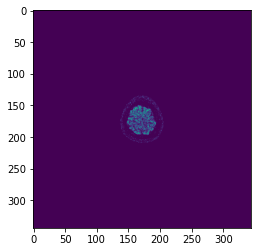

In [11]:
plt.imshow(img_noisyDataSet2[500,:,:])

In [83]:
class Unet(nn.Module):
    
    def __init__(self):
        super(Unet,self).__init__()
        
        # Contract
        self.layer1Down = nn.Sequential (
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
        self.layer2Down = nn.Sequential (
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size= 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer3Down = nn.Sequential (
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer4Down = nn.Sequential (
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer5Down = nn.Sequential (
            torch.nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
            torch.nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(),
        )
        
        self.Pooling = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        #Expand
        
        self.layer5ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 1, padding = 0)
        )
        
        self.layer4Up = nn.Sequential (
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
            torch.nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(),
        )
        
        self.layer4ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 1, padding = 0)
        )
        
        self.layer3Up = nn.Sequential (
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 128, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
        )
        
        self.layer3ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 1, padding = 0)
        )
        
        self.layer2Up = nn.Sequential (
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 64, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
        )
        
        self.layer2ConvTransposed = nn.Sequential ( 
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 1, padding = 0)
        )
        
        self.layer1Up = nn.Sequential (
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 32, kernel_size = 3, stride=1, padding=0),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
        )
        
    
    def forward(self, x):

        # Down
        conv1 = self.layer1Down(x)
        maxPool1 = self.Pooling(conv1)
        
        
        conv2 = self.layer2Down(maxPool1)
        maxPool2 = self.Pooling(conv2)
        
        conv3 = self.layer3Down(maxPool2)
        maxPool3 = self.Pooling(conv3)
        
        conv4 = self.layer4Down(maxPool3)
        maxPool4 = self.Pooling(conv4)
        
        conv5 = self.layer5Down(maxPool4)
        
        # Up
        layerConvTransposed = self.layer5ConvTransposed(conv5)
        
        print(conv4.size())
        print(layerConvTransposed.size())
        
        y = conv4[:, :, 
                  ((conv4.size()[2] - layerConvTransposed.size()[2]) // 2):conv4.size()[2]- (((conv4.size()[2] - layerConvTransposed.size()[2])-((conv4.size()[2] - layerConvTransposed.size()[2]) // 2))), 
                  ((conv4.size()[2] - layerConvTransposed.size()[2]) // 2):conv4.size()[2]-(((conv4.size()[2] - layerConvTransposed.size()[2])-((conv4.size()[2] - layerConvTransposed.size()[2]) // 2)))]
        layer4UpData = torch.cat([layerConvTransposed,y])
        convTrans4 = self.layer4Up(layer4UpData)
    
        print(layer4UpData.size())
        layerConvTransposed = self.layer4ConvTransposed(convTrans4)
        y = conv3[:, :, 
                  ((conv3.size()[2] - layerConvTransposed.size()[2]) // 2):conv3.size()[2]- (((conv3.size()[2] - layerConvTransposed.size()[2])-((conv3.size()[2] - layerConvTransposed.size()[2]) // 2))), 
                  ((conv3.size()[2] - layerConvTransposed.size()[2]) // 2):conv3.size()[2]-(((conv3.size()[2] - layerConvTransposed.size()[2])-((conv3.size()[2] - layerConvTransposed.size()[2]) // 2)))]
        layer3UpData = torch.cat([layerConvTransposed,y])
        convTrans3 = self.layer3Up(layer3UpData)
        
        layerConvTransposed = self.layer3ConvTransposed(convTrans3)
        y = conv2[:, :, 
                  ((conv2.size()[2] - layerConvTransposed.size()[2]) // 2):conv2.size()[2]- (((conv2.size()[2] - layerConvTransposed.size()[2])-((conv2.size()[2] - layerConvTransposed.size()[2]) // 2))), 
                  ((conv2.size()[2] - layerConvTransposed.size()[2]) // 2):conv2.size()[2]-(((conv2.size()[2] - layerConvTransposed.size()[2])-((conv2.size()[2] - layerConvTransposed.size()[2]) // 2)))]
        layer2UpData = torch.cat([layerConvTransposed,y])
        convTrans2 = self.layer2Up(layer2UpData)
        
        layerConvTransposed = self.layer2ConvTransposed(convTrans2)
        y = conv1[:, :, 
                  ((conv1.size()[2] - layerConvTransposed.size()[2]) // 2):conv1.size()[2]- (((conv1.size()[2] - layerConvTransposed.size()[2])-((conv1.size()[2] - layerConvTransposed.size()[2]) // 2))), 
                  ((conv1.size()[2] - layerConvTransposed.size()[2]) // 2):conv1.size()[2]-(((conv1.size()[2] - layerConvTransposed.size()[2])-((conv1.size()[2] - layerConvTransposed.size()[2]) // 2)))]
        layer1UpData = torch.cat([layerConvTransposed,y])
        convTrans1 = self.layer1Up(layer1UpData)


        outNet = torch.nn.Conv2d(32,2, kernel_size = 1)(convTrans1)
        return outNet

        

In [84]:
if __name__ == '__main__':
    image = torch.rand((1, 1, 572, 572))
    model = Unet()
    model(image)

torch.Size([1, 256, 66, 66])
torch.Size([1, 256, 30, 30])
torch.Size([2, 256, 30, 30])
